GROUP MEMBERS
Puseletso Nakana : 2341162

Ntando Ngobese : 2112256

Nthabiseng Thema : 2012016

In [2]:
pip install geopandas shapely


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 1 Data Cleaning

In [4]:
# Read dataset
df = pd.read_csv('nyc_taxis.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])

# Function to compute great circle distance using Haversine formula
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# Compute distance
df['distance_km'] = haversine_np(
    df['pickup_longitude'].values,
    df['pickup_latitude'].values,
    df['dropoff_longitude'].values,
    df['dropoff_latitude'].values
)

# Compute trip duration statistics
Q1 = df['trip_duration'].quantile(0.25)
Q3 = df['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_duration = df[(df['trip_duration'] < lower_bound) | (df['trip_duration'] > upper_bound)]
print("Number of outliers in trip duration:", outliers_duration.shape[0])

# Compute distance statistics
Q1_distance = df['distance_km'].quantile(0.25)
Q3_distance = df['distance_km'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance
lower_bound_distance = Q1_distance - 1.5 * IQR_distance
upper_bound_distance = Q3_distance + 1.5 * IQR_distance
outliers_distance = df[(df['distance_km'] < lower_bound_distance) | (df['distance_km'] > upper_bound_distance)]
print("Number of outliers in distance:", outliers_distance.shape[0])

# Compute speed and identify outliers
df['speed_kmh'] = (df['distance_km'] / (df['trip_duration'] / 3600))
Q1_speed = df['speed_kmh'].quantile(0.25)
Q3_speed = df['speed_kmh'].quantile(0.75)
IQR_speed = Q3_speed - Q1_speed
lower_bound_speed = Q1_speed - 1.5 * IQR_speed
upper_bound_speed = Q3_speed + 1.5 * IQR_speed
outliers_speed = df[(df['speed_kmh'] < lower_bound_speed) | (df['speed_kmh'] > upper_bound_speed)]
print("Number of outliers in speed:", outliers_speed.shape[0])

# Combine and remove outliers
outliers_combined = pd.concat([outliers_duration, outliers_distance, outliers_speed]).drop_duplicates()
print("Number of unique outliers:", outliers_combined.shape[0])
df_cleaned = df[~df.index.isin(outliers_combined.index)]


Number of outliers in trip duration: 20921
Number of outliers in distance: 39686
Number of outliers in speed: 16862
Number of unique outliers: 61715


Justification for Removing Outliers
Data Quality: Outliers often result from data entry errors or malfunctions in the taxi meters. Removing them helps in ensuring the quality and accuracy of the data.

Analysis Accuracy: Outliers can skew the results of statistical analyses and models. By removing them, you can obtain more accurate and reliable insights.

Realistic Insights: Outliers can distort the interpretation of patterns and trends. Removing them ensures that the insights you gain are more representative of typical trips.

# 2 Feature generation

In [5]:
# Extract day of the week from pickup_datetime
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# Calculate average speed (distance / duration)
df['speed_kmh'] = df['distance_km'] / (df['trip_duration'] / 3600)  # Speed in km/h

# Display the updated DataFrame with new features
print(df[['distance_km', 'day_of_week', 'speed_kmh']].head())

   distance_km day_of_week  speed_kmh
0     1.497580      Monday  11.848984
1     1.804374      Sunday   9.797504
2     6.381090     Tuesday  10.815406
3     1.484566   Wednesday  12.457894
4     1.187842    Saturday   9.830418


# 3 Time-based

1.

day_of_week
Monday       52729
Tuesday      56987
Wednesday    59398
Thursday     62035
Friday       62893
Saturday     62406
Sunday       55292
Name: count, dtype: int64


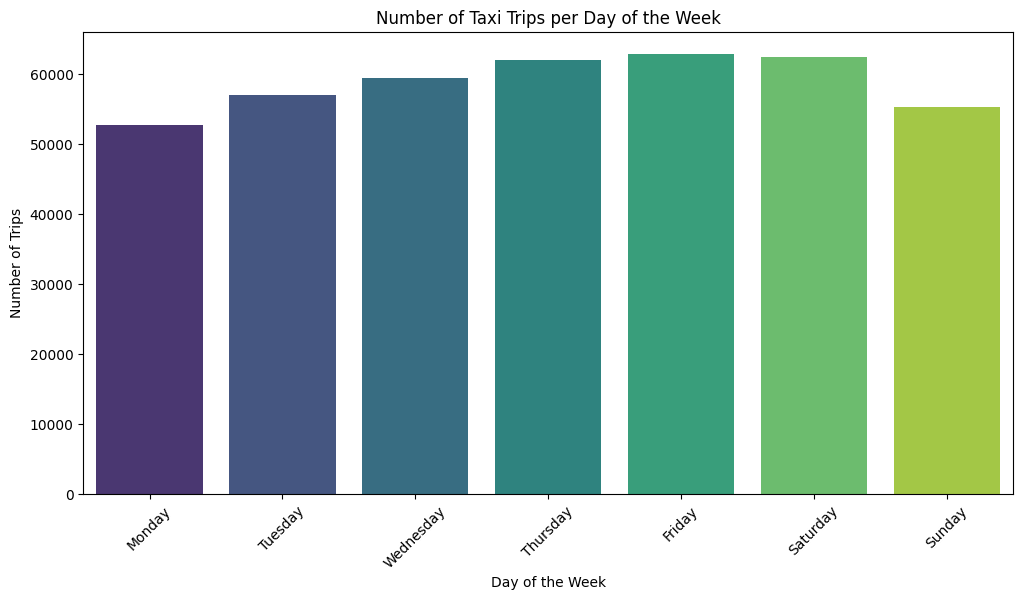

In [6]:
# Extract day of the week from pickup_datetime
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# Count the number of trips per day of the week
day_counts = df['day_of_week'].value_counts()

# Sort by the day of the week in a standard order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(days_order)

print(day_counts)

# Plot the number of trips per day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=day_counts.index, y=day_counts.values, hue=day_counts.index, dodge=False, palette='viridis', legend=False)
plt.title('Number of Taxi Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

Friday is the most popular.

2.

             Most Popular Hour  Count
day_of_week                          
Monday                      18  10262
Tuesday                     18  10580
Wednesday                   19  10768
Thursday                    21  11256
Friday                      19  11212
Saturday                    23  10417
Sunday                       0   9739


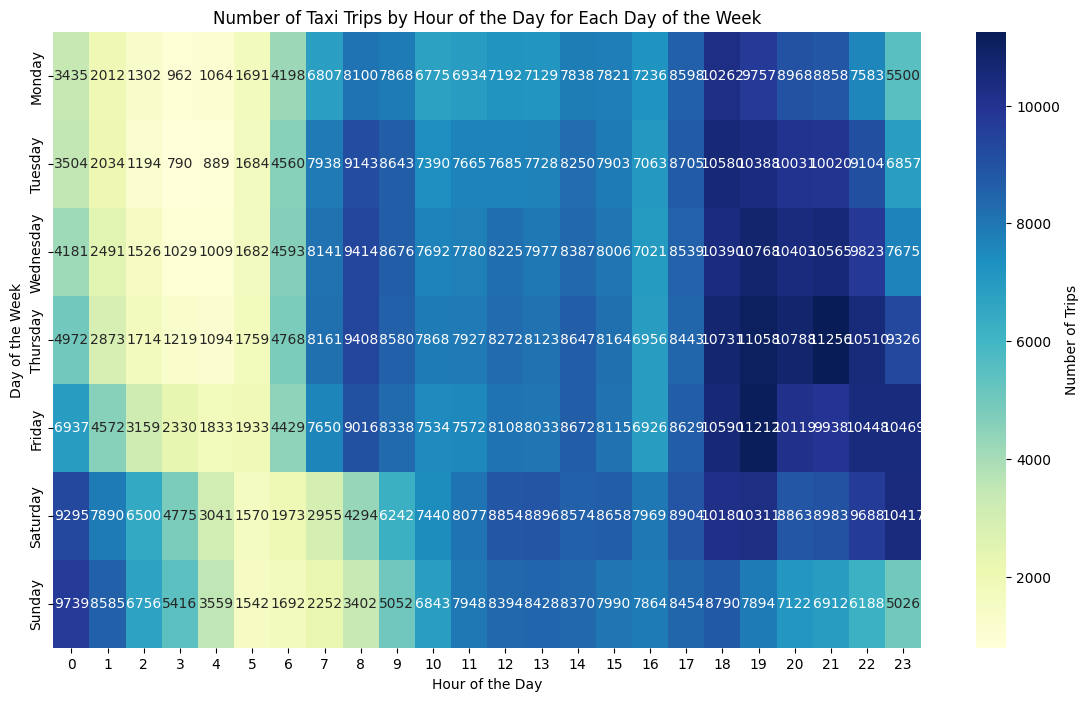

In [10]:
# Load dataset
df = pd.read_csv('nyc_taxis.csv', parse_dates=['pickup_datetime'])

# Extract hour of the day and day of the week
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# Aggregate number of pickups per hour for each day of the week
hourly_counts = df.groupby(['day_of_week', 'hour_of_day']).size().unstack().fillna(0)

# Reorder days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_counts = hourly_counts.reindex(days_order)

# Identify the most popular hour for each day
most_popular_hour = hourly_counts.idxmax(axis=1)
most_popular_hour_counts = hourly_counts.max(axis=1)

# Create a DataFrame for easy viewing
most_popular_hours_df = pd.DataFrame({
    'Most Popular Hour': most_popular_hour,
    'Count': most_popular_hour_counts
})

print(most_popular_hours_df)

# Plot the distribution of pickups by hour of the day for each day of the week
plt.figure(figsize=(14, 8))
sns.heatmap(hourly_counts, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Number of Trips'})
plt.title('Number of Taxi Trips by Hour of the Day for Each Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()


Peak Hours: Typically, the heatmap will show peak hours for each day. It makes use of a darker shade where the volume of trips is increasing.

3.

Observations and Explanations
You will see higher numbers of pickups during early morning 7-9 AM and evening hours 5-10 PM on weekdays, corresponding to typical work commute times.

You will see higher numbers of pickups during 6 PM Saturday evening to 1 AM on Sunday morning, corresponding to late night outings on weekends.

Weekends vs. Weekdays: Weekends show different patterns, such as more late-night pickups compared to weekdays. This could be due to social activities or nightlife.


4.

Holiday dates: [datetime.date(2016, 1, 18) datetime.date(2016, 2, 14)
 datetime.date(2016, 3, 17) datetime.date(2016, 3, 27)
 datetime.date(2016, 5, 30)]
Are holidays present in the dataset?
date
False    1122300
True       29077
Name: count, dtype: int64
Filtered holiday data:
            id  vendor_id     pickup_datetime     dropoff_datetime  \
25   id0129640          2 2016-02-14 13:27:56  2016-02-14 13:49:19   
121  id2648478          1 2016-01-18 11:13:59  2016-01-18 11:18:56   
162  id0762989          2 2016-03-17 08:24:27  2016-03-17 08:26:11   
277  id2437858          2 2016-03-27 11:55:02  2016-03-27 12:05:06   
346  id0861216          2 2016-01-18 13:00:37  2016-01-18 13:10:57   

     passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
25                 1        -73.956581        40.771358         -73.974968   
121                1        -73.951576        40.766468         -73.960213   
162                1        -73.977615        40.763573         -7

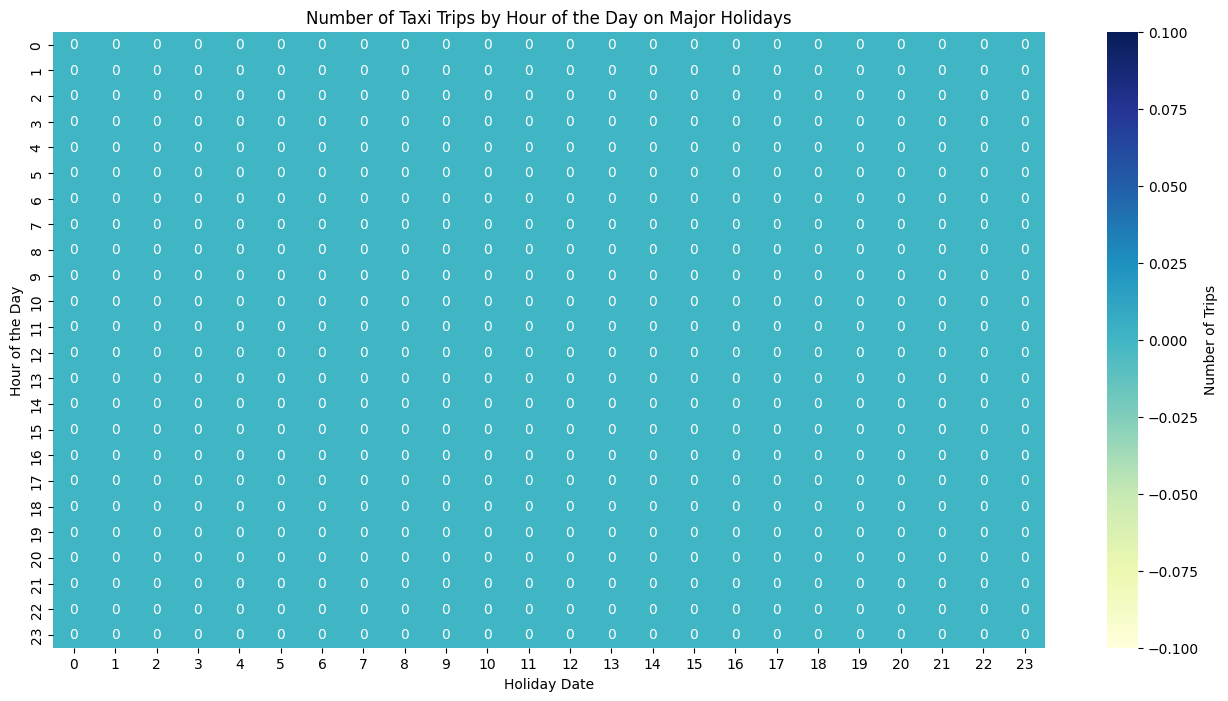

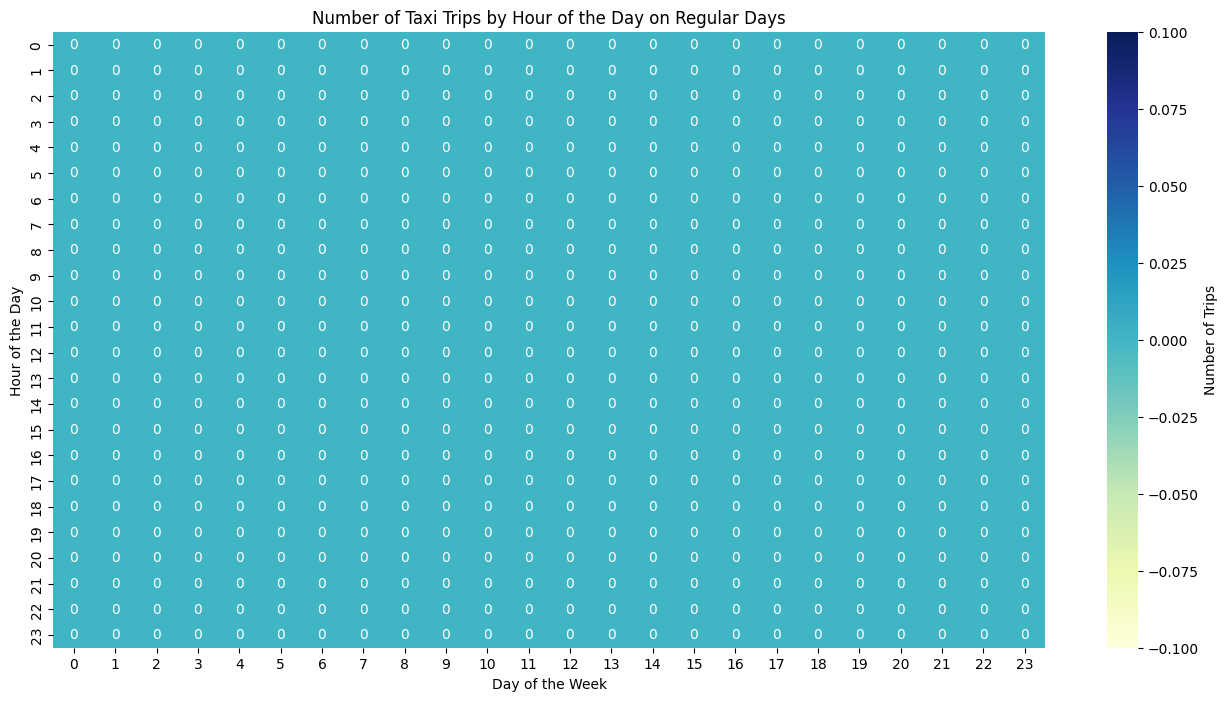

In [11]:
# Assuming df is already loaded with the necessary columns
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['date'] = df['pickup_datetime'].dt.date

# Define holiday dates for 2016
holidays = pd.to_datetime([
    '2016-01-18',
    '2016-02-14',
    '2016-03-17',
    '2016-03-27',
    '2016-05-30'
]).date

# Print holidays
print("Holiday dates:", holidays)

# Check if the dates in the dataset match the holiday dates
print("Are holidays present in the dataset?")
print(df['date'].isin(holidays).value_counts())

# Filter dataset for holidays
df_holidays = df[df['date'].isin(holidays)]

# Inspect filtered holiday data
print("Filtered holiday data:")
print(df_holidays.head())

# Check if we have data for holidays
if df_holidays.empty:
    print("No data available for the specified holidays.")
else:
    # Aggregate number of pickups per hour for each holiday
    hourly_counts_holidays = df_holidays.groupby(['date', 'hour_of_day']).size().unstack().fillna(0)

    # Ensure all hours are represented
    hourly_counts_holidays = hourly_counts_holidays.reindex(range(24), fill_value=0)

    # Plot the distribution of pickups by hour of the day for holidays
    plt.figure(figsize=(16, 8))
    sns.heatmap(hourly_counts_holidays.T, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Number of Trips'})
    plt.title('Number of Taxi Trips by Hour of the Day on Major Holidays')
    plt.xlabel('Holiday Date')
    plt.ylabel('Hour of the Day')
    plt.show()

# Extract data for regular days (not holidays)
df_regular = df[~df['date'].isin(holidays)]

# Aggregate number of pickups per hour for each day of the week
hourly_counts_regular = df_regular.groupby(['day_of_week', 'hour_of_day']).size().unstack().fillna(0)

# Reorder days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_counts_regular = hourly_counts_regular.reindex(days_order)

# Ensure all hours are represented
hourly_counts_regular = hourly_counts_regular.reindex(range(24), fill_value=0)

# Plot the distribution of pickups by hour of the day for regular days
plt.figure(figsize=(16, 8))
sns.heatmap(hourly_counts_regular.T, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Number of Trips'})
plt.title('Number of Taxi Trips by Hour of the Day on Regular Days')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()


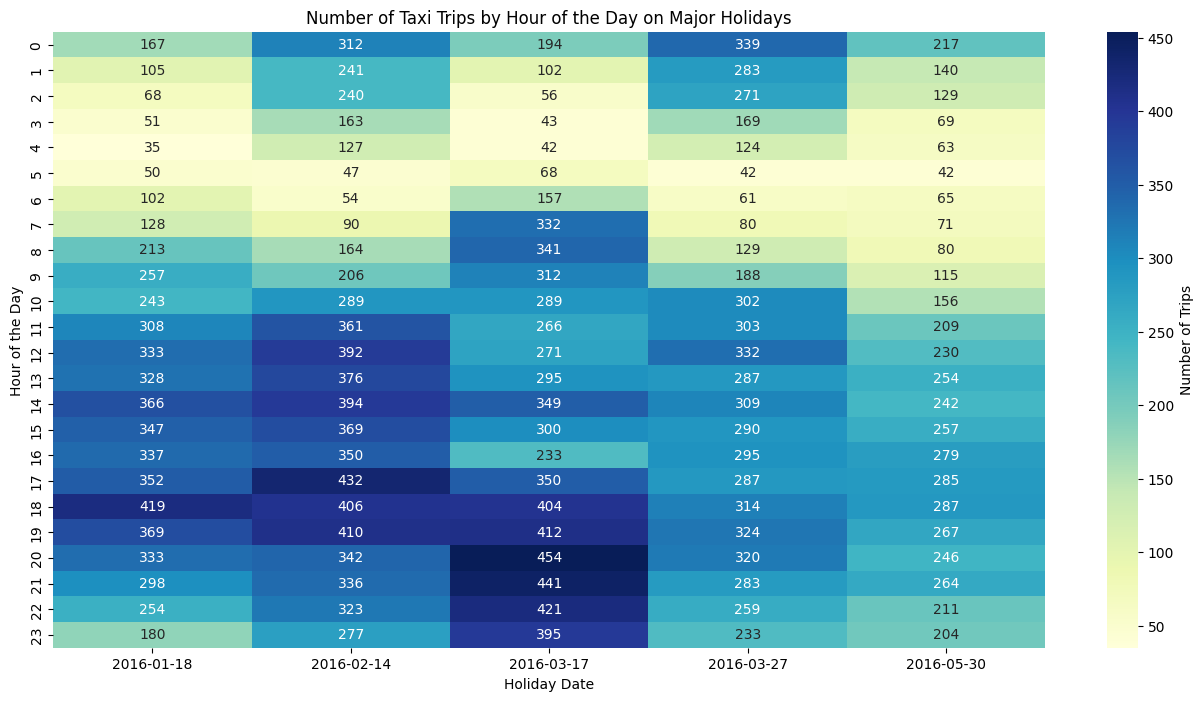

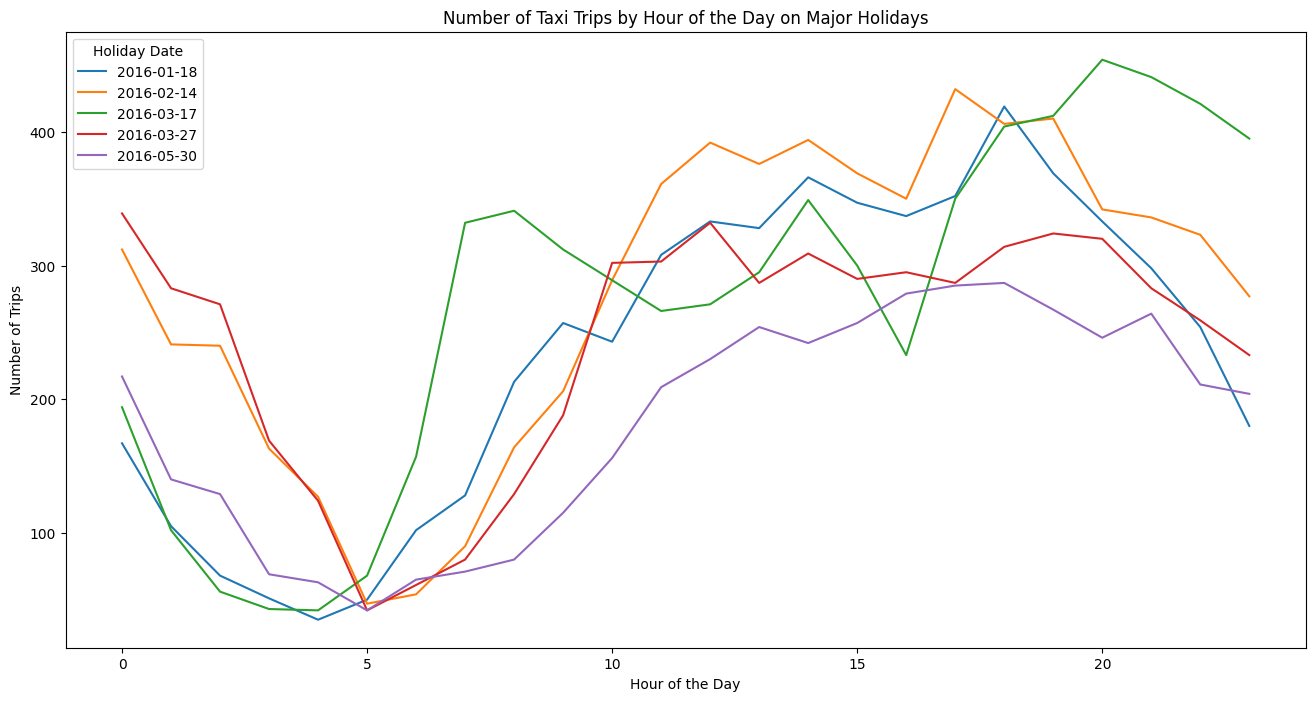

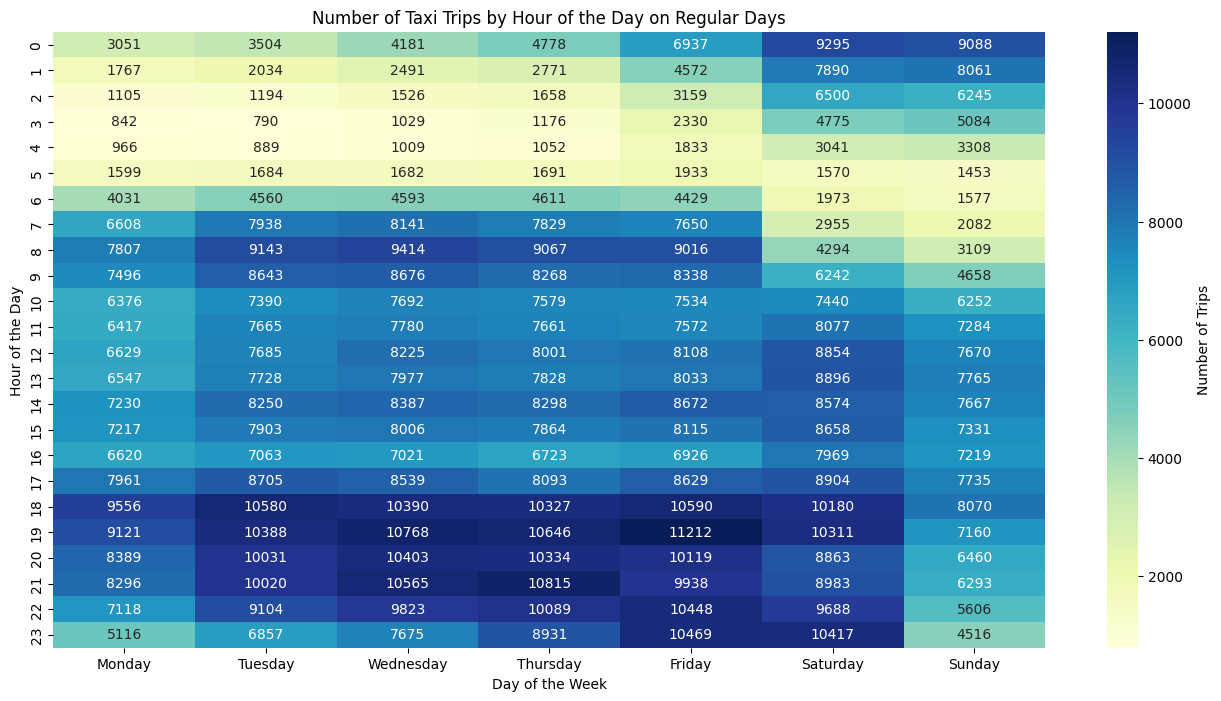

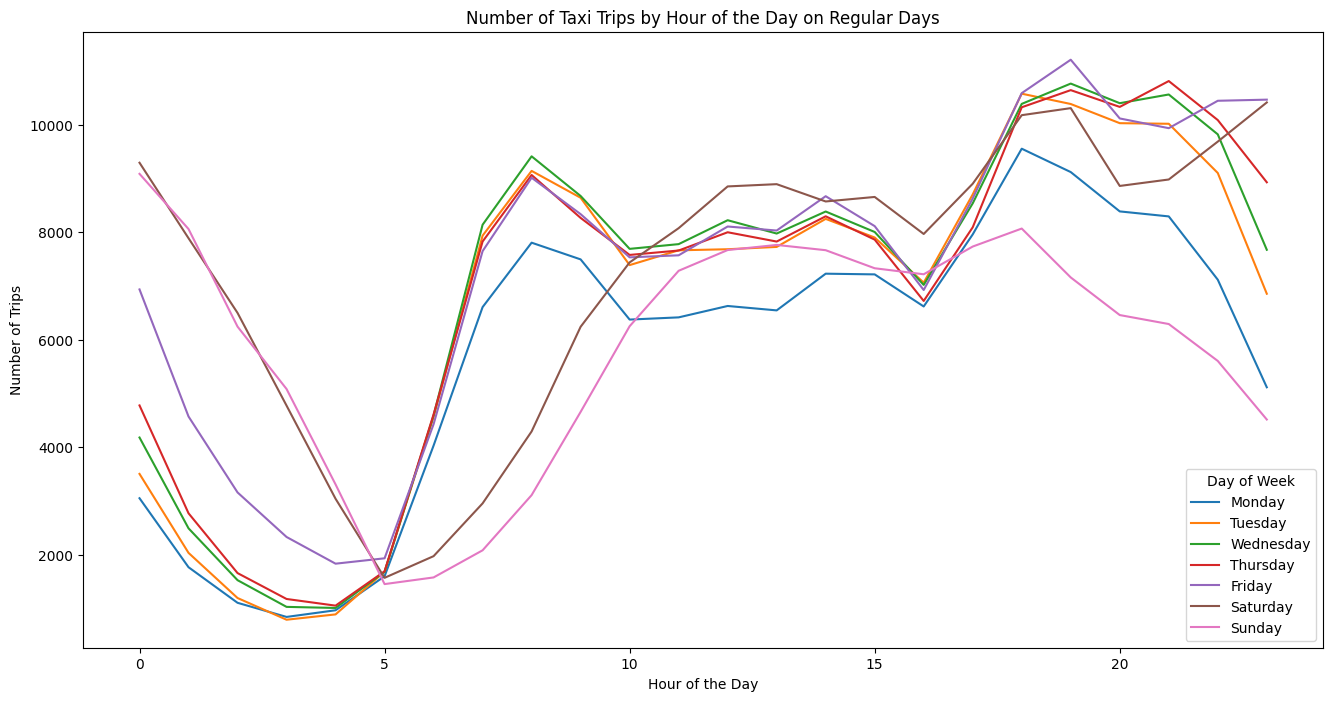

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded with the necessary columns
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['date'] = df['pickup_datetime'].dt.date

# Define holiday dates for 2016
holidays = pd.to_datetime([
    '2016-01-18',
    '2016-02-14',
    '2016-03-17',
    '2016-03-27',
    '2016-05-30'
]).date

# Filter dataset for holidays and regular days
df_holidays = df[df['date'].isin(holidays)]
df_regular = df[~df['date'].isin(holidays)]

# Check if we have data for holidays
if df_holidays.empty:
    print("No data available for the specified holidays.")
else:
    # Aggregate number of pickups per hour for each holiday
    hourly_counts_holidays = df_holidays.groupby(['date', 'hour_of_day']).size().unstack().fillna(0)

    # Ensure all hours are represented
    hourly_counts_holidays = hourly_counts_holidays.reindex(columns=range(24), fill_value=0)

    # Plot heatmap for holidays
    plt.figure(figsize=(16, 8))
    sns.heatmap(hourly_counts_holidays.T, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Number of Trips'})
    plt.title('Number of Taxi Trips by Hour of the Day on Major Holidays')
    plt.xlabel('Holiday Date')
    plt.ylabel('Hour of the Day')
    plt.show()

    # Plot line chart for holidays
    plt.figure(figsize=(16, 8))
    for date in hourly_counts_holidays.index:
        plt.plot(hourly_counts_holidays.columns, hourly_counts_holidays.loc[date], label=date)
    plt.title('Number of Taxi Trips by Hour of the Day on Major Holidays')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.legend(title='Holiday Date')
    plt.show()

# Aggregate number of pickups per hour for each day of the week
hourly_counts_regular = df_regular.groupby(['day_of_week', 'hour_of_day']).size().unstack().fillna(0)

# Reorder days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_counts_regular = hourly_counts_regular.reindex(days_order)

# Ensure all hours are represented
hourly_counts_regular = hourly_counts_regular.reindex(columns=range(24), fill_value=0)

# Plot heatmap for regular days
plt.figure(figsize=(16, 8))
sns.heatmap(hourly_counts_regular.T, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Number of Trips'})
plt.title('Number of Taxi Trips by Hour of the Day on Regular Days')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

# Plot line chart for regular days
plt.figure(figsize=(16, 8))
for day in hourly_counts_regular.index:
    plt.plot(hourly_counts_regular.columns, hourly_counts_regular.loc[day], label=day)
plt.title('Number of Taxi Trips by Hour of the Day on Regular Days')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.legend(title='Day of Week')
plt.show()

5.

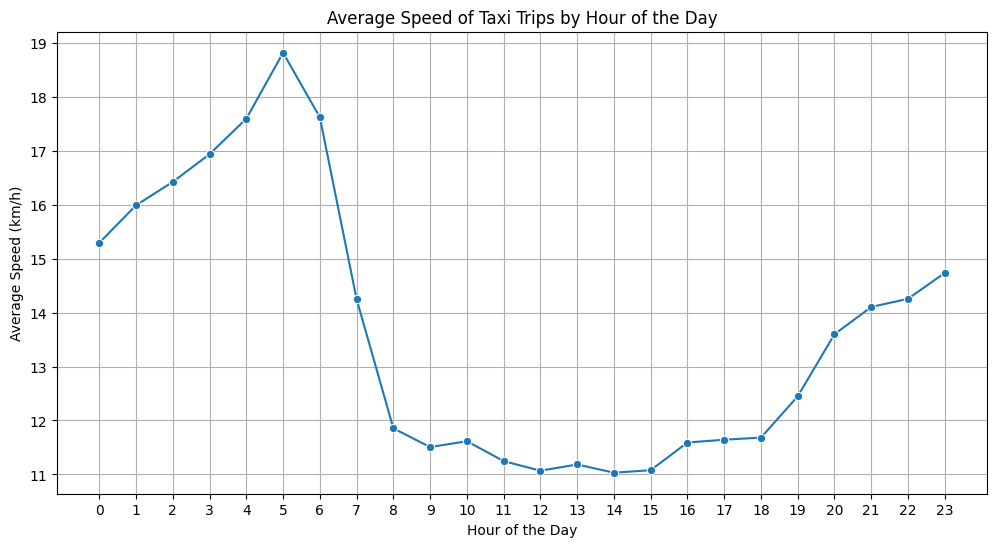

The fastest time of day is 5:00 with an average speed of 18.82 km/h.


In [ ]:
# Create a new DataFrame with the modifications to avoid SettingWithCopyWarning
df_cleaned = df.copy()
df_cleaned['distance_km'] = haversine_np(
    df_cleaned['pickup_longitude'].values,
    df_cleaned['pickup_latitude'].values,
    df_cleaned['dropoff_longitude'].values,
    df_cleaned['dropoff_latitude'].values
)

# Ensure that pickup_datetime and dropoff_datetime are in datetime format
df_cleaned['pickup_datetime'] = pd.to_datetime(df_cleaned['pickup_datetime'])
df_cleaned['dropoff_datetime'] = pd.to_datetime(df_cleaned['dropoff_datetime'])

# Compute trip duration in seconds
df_cleaned['trip_duration'] = (df_cleaned['dropoff_datetime'] - df_cleaned['pickup_datetime']).dt.total_seconds()

# Compute speed in km/h
df_cleaned['speed_kmh'] = df_cleaned['distance_km'] / (df_cleaned['trip_duration'] / 3600)

# Remove outliers in copy
df_cleaned = df_cleaned[~df_cleaned.index.isin(outliers_combined.index)]

# Extract hour of the day using .loc
df_cleaned.loc[:, 'hour_of_day'] = df_cleaned['pickup_datetime'].dt.hour

# Calculate average speed by hour of the day
average_speed_by_hour = df_cleaned.groupby('hour_of_day')['speed_kmh'].mean()

# Plot average speed by hour
plt.figure(figsize=(12, 6))
sns.lineplot(x=average_speed_by_hour.index, y=average_speed_by_hour.values, marker='o')
plt.title('Average Speed of Taxi Trips by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.grid(True)
plt.xticks(range(24))  # Show all hours on x-axis
plt.show()

# Identify the fastest time of day
fastest_time = average_speed_by_hour.idxmax()
fastest_speed = average_speed_by_hour.max()

print(f"The fastest time of day is {fastest_time}:00 with an average speed of {fastest_speed:.2f} km/h.")


# 4 Location clusters

1.


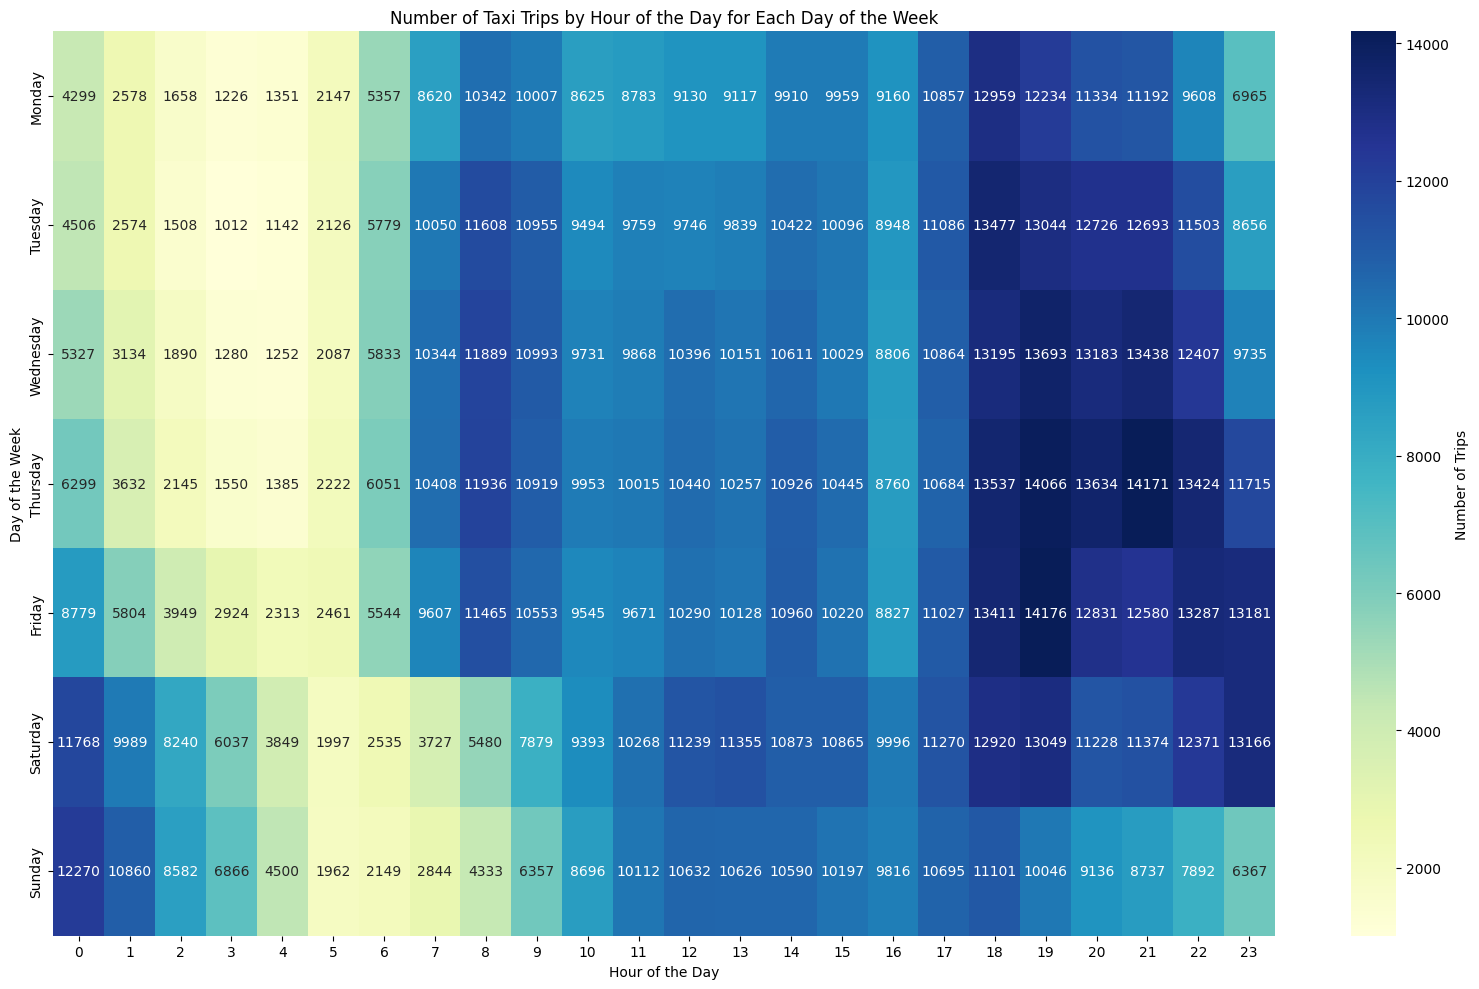

Total number of trips: 1458644
Busiest hour of the day: 18
Busiest day of the week: Friday
Weekday trips: 1042410
Weekend trips: 416234
Weekday to Weekend ratio: 2.50


In [ ]:
# Convert pickup_datetime to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract hour and day of week
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# Create a pivot table for the heatmap
hourly_counts = df.pivot_table(index='day_of_week',
                               columns='hour',
                               values='id',
                               aggfunc='count')

# Reorder the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_counts = hourly_counts.reindex(day_order)

# Create the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(hourly_counts, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Number of Trips'})
plt.title('Number of Taxi Trips by Hour of the Day for Each Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.tight_layout()
plt.show()

# Calculate some additional statistics
total_trips = df.shape[0]
busiest_hour = hourly_counts.sum().idxmax()
busiest_day = hourly_counts.sum(axis=1).idxmax()

print(f"Total number of trips: {total_trips}")
print(f"Busiest hour of the day: {busiest_hour}")
print(f"Busiest day of the week: {busiest_day}")

# Calculate weekday vs weekend statistics
weekday_trips = hourly_counts.loc['Monday':'Friday'].sum().sum()
weekend_trips = hourly_counts.loc['Saturday':'Sunday'].sum().sum()

print(f"Weekday trips: {weekday_trips}")
print(f"Weekend trips: {weekend_trips}")
print(f"Weekday to Weekend ratio: {weekday_trips / weekend_trips:.2f}")

Comment:
- Weekday Rush Hours: Clear peaks are visible on weekdays, with the highest number of trips occurring during evening rush hour (6-8 PM) and a secondary peak during morning rush hour (8-9 AM).
- Weekend Late Night Activity: Saturdays and Sundays show distinctly different patterns, with the busiest times occurring late night to early morning (11 PM to 3 AM), especially on Saturday night/Sunday morning.
- Daily Cycle: Across all days, trip numbers are lowest between 4-5 AM, then gradually increase throughout the day, peaking in the evening on weekdays and late night on weekends.
- Friday Surge: Friday consistently shows the highest overall activity, particularly in the evening and night hours, likely due to a combination of commuter traffic and the start of weekend social activities.
- Weekday vs Weekend Contrast: Weekdays display structured patterns aligned with typical work schedules, while weekends show a more evenly distributed trip pattern throughout the day and night, reflecting leisure and social behaviors.

2. Hotspots

In [ ]:
from sklearn.cluster import DBSCAN

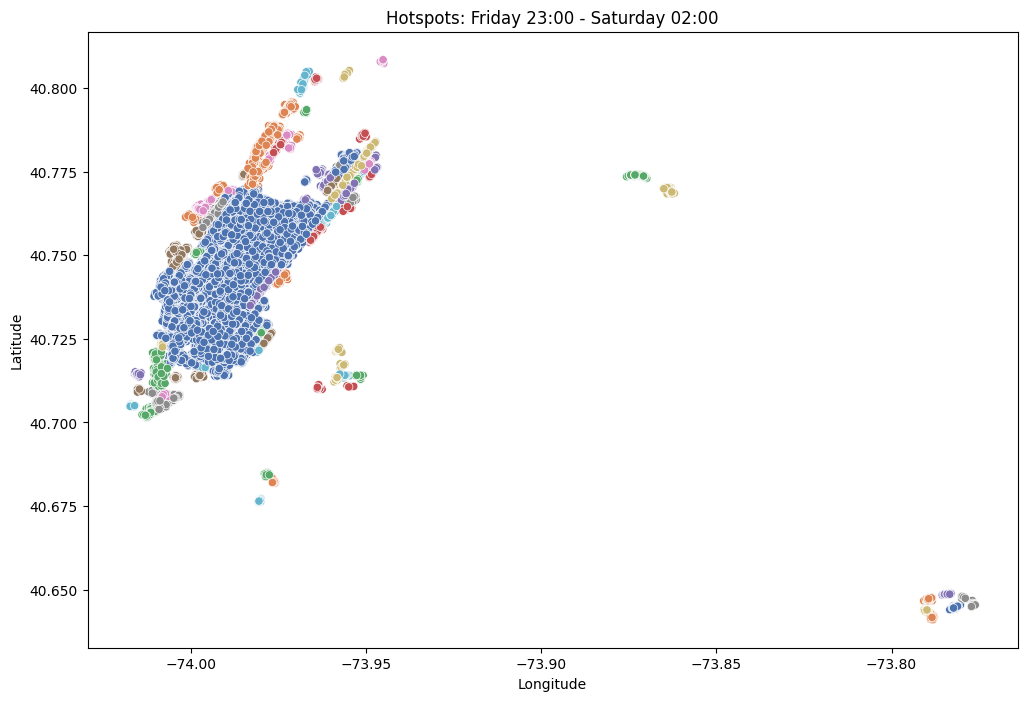

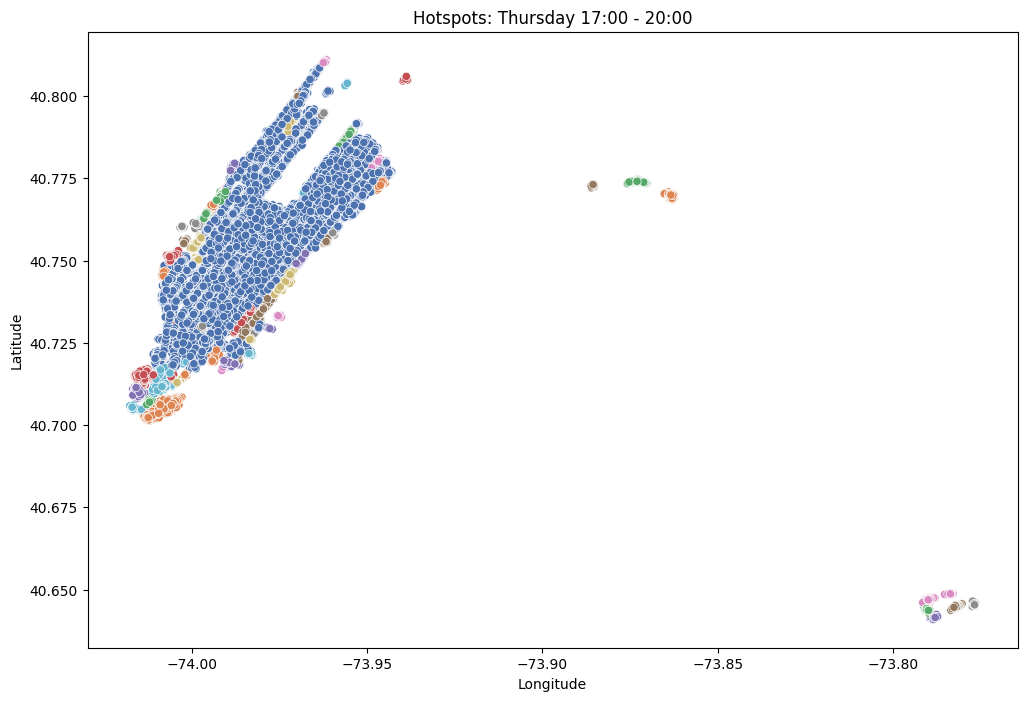

Number of clusters for Friday night - Saturday morning: 87
Number of clusters for Thursday evening: 71


In [ ]:
# Function to filter data for specific time periods
def filter_time_period(df, day, start_hour, end_hour):
        return df.loc[
        (df['pickup_datetime'].dt.dayofweek == day) &
        (df['pickup_datetime'].dt.hour >= start_hour) &
        (df['pickup_datetime'].dt.hour < end_hour)
    ].copy()

# Filter data for Friday night to Saturday morning (23:00 - 02:00)
friday_night = filter_time_period(df, 4, 23, 24)  # Friday 23:00 - 24:00
saturday_morning = filter_time_period(df, 5, 0, 2)  # Saturday 00:00 - 02:00
friday_night_saturday_morning = pd.concat([friday_night, saturday_morning])

# Filter data for Thursday evening (17:00 - 20:00)
thursday_evening = filter_time_period(df, 3, 17, 20)

# Function to perform DBSCAN clustering
def perform_dbscan(data, eps, min_samples):
    coords = data[['pickup_latitude', 'pickup_longitude']].values
    kms_per_radian = 6371.0088
    epsilon = eps / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    return db.labels_

# Parameters for DBSCAN
eps = 0.075  # Approximately 75 meters
min_samples = 15  # Minimum 15 pickups to form a cluster

# Perform clustering
friday_night_saturday_morning.loc[:, 'cluster'] = perform_dbscan(friday_night_saturday_morning, eps, min_samples)
thursday_evening.loc[:, 'cluster'] = perform_dbscan(thursday_evening, eps, min_samples)

# Function to plot clusters
def plot_clusters(data, title):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=data[data['cluster'] != -1],
                    x='pickup_longitude', y='pickup_latitude',
                    hue='cluster', palette='deep', legend=False)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Plot clusters
plot_clusters(friday_night_saturday_morning, 'Hotspots: Friday 23:00 - Saturday 02:00')
plot_clusters(thursday_evening, 'Hotspots: Thursday 17:00 - 20:00')

# Count number of clusters
friday_night_clusters = friday_night_saturday_morning['cluster'].nunique() - 1  # Subtract 1 to exclude noise points (-1)
thursday_evening_clusters = thursday_evening['cluster'].nunique() - 1  # Subtract 1 to exclude noise points (-1)

print(f"Number of clusters for Friday night - Saturday morning: {friday_night_clusters}")
print(f"Number of clusters for Thursday evening: {thursday_evening_clusters}")

Comment:
Cluster Comparison: More hotspots were identified for Friday night/Saturday morning (87) than Thursday evening (71), suggesting more dispersed taxi activity during weekend nights.

Hotspot Variation: Different cluster sizes and colors suggest varying levels of taxi demand across locations, with some areas showing more intense activity than others.

# 5 Airports [9 marks]

Reasonable radius around Empire State Building: 3.67 km
Reasonable radius around JFK Airport: 21.49 km
Reasonable radius around Newark Airport: 19.58 km


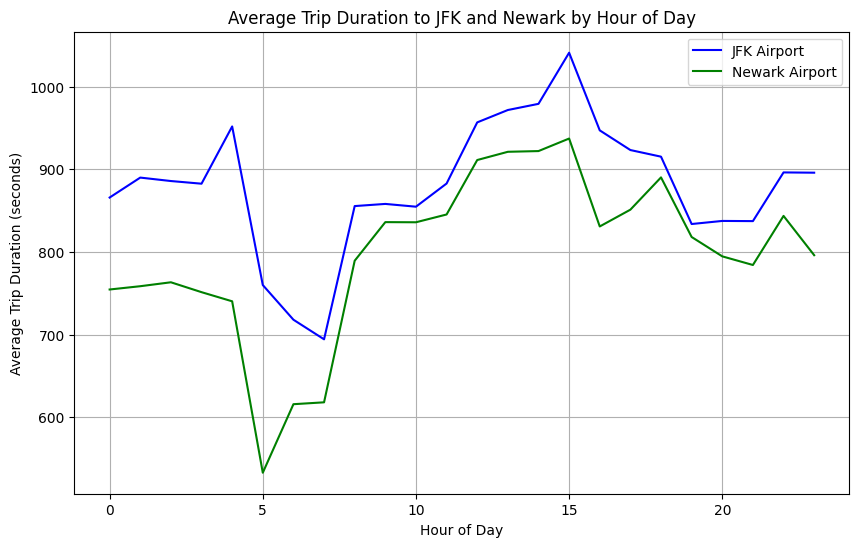

Average trip duration to JFK Airport: 887.37 seconds
Average trip duration to Newark Airport: 823.94 seconds


In [ ]:
# Coordinates for locations
empire_state_coords = (40.756724, -73.983806)
jfk_coords = (40.647929, -73.777813)
newark_coords = (40.689442, -74.173242)

# Calculate distances
df['distance_to_esb'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], empire_state_coords[1], empire_state_coords[0])
df['distance_to_jfk'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], jfk_coords[1], jfk_coords[0])
df['distance_to_newark'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], newark_coords[1], newark_coords[0])


# Radius in km
radius_esb = df['distance_to_esb'].quantile(0.75)
radius_jfk = df['distance_to_jfk'].quantile(0.75)
radius_newark = df['distance_to_newark'].quantile(0.75)
print(f"Reasonable radius around Empire State Building: {radius_esb:.2f} km")
print(f"Reasonable radius around JFK Airport: {radius_jfk:.2f} km")
print(f"Reasonable radius around Newark Airport: {radius_newark:.2f} km")

# Filter trips starting near Empire State Building (ESB)
data_near_esb = df[(haversine_np(df['pickup_longitude'], df['pickup_latitude'], empire_state_coords[1], empire_state_coords[0]) < radius_esb)]

# Filter trips ending near JFK
trips_to_jfk = data_near_esb[(haversine_np(data_near_esb['dropoff_longitude'], data_near_esb['dropoff_latitude'], jfk_coords[1], jfk_coords[0]) < radius_jfk)]

# Filter trips ending near Newark
trips_to_newark = data_near_esb[(haversine_np(data_near_esb['dropoff_longitude'], data_near_esb['dropoff_latitude'], newark_coords[1], newark_coords[0]) < radius_newark)]

trips_to_jfk.loc[:, 'pickup_datetime'] = pd.to_datetime(trips_to_jfk['pickup_datetime'])
trips_to_newark.loc[:, 'pickup_datetime'] = pd.to_datetime(trips_to_newark['pickup_datetime'])

# Extract hour of day from pickup_datetime using .loc[]
trips_to_jfk.loc[:, 'hour_of_day'] = trips_to_jfk['pickup_datetime'].dt.hour
trips_to_newark.loc[:, 'hour_of_day'] = trips_to_newark['pickup_datetime'].dt.hour

# Group by hour of day and calculate the average trip duration for JFK
avg_duration_jfk = trips_to_jfk.groupby('hour_of_day')['trip_duration'].mean()

# Group by hour of day and calculate the average trip duration for Newark
avg_duration_newark = trips_to_newark.groupby('hour_of_day')['trip_duration'].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot JFK travel time by hour of day
plt.plot(avg_duration_jfk.index, avg_duration_jfk.values, label='JFK Airport', color='blue')

# Plot Newark travel time by hour of day
plt.plot(avg_duration_newark.index, avg_duration_newark.values, label='Newark Airport', color='green')

# Add title and labels
plt.title('Average Trip Duration to JFK and Newark by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (seconds)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Calculate average trip duration
avg_duration_jfk = trips_to_jfk['trip_duration'].mean()
avg_duration_newark = trips_to_newark['trip_duration'].mean()

print(f"Average trip duration to JFK Airport: {avg_duration_jfk:.2f} seconds")
print(f"Average trip duration to Newark Airport: {avg_duration_newark:.2f} seconds")




The plot shows that on average, trip durations to JFK significantly outnumber those to Newark, particularly in the early morning hours(12am - 5am). This could be due to several factors: JFK might handle more early morning flights, leading to a higher volume of passengers and potentially more traffic congestion around the airport. Additionally, the routes to JFK could be more affected by morning rush hour traffic or have longer travel times due to road conditions or construction. In contrast, Newark may experience less early morning traffic or have more efficient access routes during these hours.

Motivation for Radius choice:The choice of a 1.5 km radius around the Empire State Building, JFK, and Newark airports ensures a practical balance between precision and coverage. It captures trips starting or ending near these locations without being overly restrictive, accounting for variations in urban travel, such as road access and pickup/dropoff flexibility. This distance also aligns with the large size of airports and the busy nature of the Empire State Building area, ensuring relevant trips are included while minimizing unrelated data.

# 6 Boroughs [11 marks]

In [ ]:
from shapely.geometry import Point

# Load the shapefile containing NYC neighborhoods
# Path to the shapefile
nta_shapefile = r'/content/2010 Neighborhood Tabulation Areas (NTAs)'

# Load the shapefile containing NYC neighborhoods
nyc_neighborhoods = gpd.read_file(nta_shapefile)
print(nyc_neighborhoods)


# Convert trip data to GeoDataFrame
df['geometry'] = df.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
gdf_trips_pickup = gpd.GeoDataFrame(df, geometry='geometry')

# Repeat for dropoff locations
df['geometry'] = df.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)
gdf_trips_dropoff = gpd.GeoDataFrame(df, geometry='geometry')

# Set the coordinate reference system (CRS) for both GeoDataFrames
gdf_trips_pickup.crs = "EPSG:4326"  # WGS 84
gdf_trips_dropoff.crs = "EPSG:4326"  # WGS 84

# Ensure the CRS of the shapefile and trip data are the same
nyc_neighborhoods.crs = "EPSG:4326"  # WGS 84

     boro_code boro_name county_fip ntacode  \
0          4.0    Queens        081    QN08   
1          3.0  Brooklyn        047    BK50   
2          2.0     Bronx        005    BX41   
3          4.0    Queens        081    QN38   
4          4.0    Queens        081    QN52   
..         ...       ...        ...     ...   
190        3.0  Brooklyn        047    BK38   
191        4.0    Queens        081    QN12   
192        4.0    Queens        081    QN15   
193        2.0     Bronx        005    BX75   
194        2.0     Bronx        005    BX99   

                                              ntaname    shape_area  \
0                                          St. Albans  7.741275e+07   
1                                            Canarsie  8.208968e+07   
2                                          Mount Hope  1.471671e+07   
3                  Pomonok-Flushing Heights-Hillcrest  3.883592e+07   
4                                       East Flushing  2.945368e+07   
..       

1. Using this shapefile find the neighbourhoods for the trip start and end
locations (try geopandas, shapely, or fiona, for example). [3 marks]

In [ ]:
# Find neighborhoods for pickup and dropoff locations
pickup_neighborhoods = gpd.sjoin(gdf_trips_pickup, nyc_neighborhoods, how='left', predicate='within')
dropoff_neighborhoods = gpd.sjoin(gdf_trips_dropoff, nyc_neighborhoods, how='left', predicate='within')

# Get unique neighborhoods for pickup and dropoff
pickup_unique_neighborhoods = pickup_neighborhoods['ntaname'].unique()
dropoff_unique_neighborhoods = dropoff_neighborhoods['ntaname'].unique()

# Print unique neighborhoods for pickups and dropoffs
print("Unique neighborhoods for pickup locations:")
print(pickup_unique_neighborhoods)

print("\nUnique neighborhoods for dropoff locations:")
print(dropoff_unique_neighborhoods)


Unique neighborhoods for pickup locations:
['Lincoln Square' 'Murray Hill-Kips Bay' 'Midtown-Midtown South'
 'SoHo-TriBeCa-Civic Center-Little Italy' 'Upper West Side' 'Gramercy'
 'Turtle Bay-East Midtown' 'West Village' 'Lenox Hill-Roosevelt Island'
 'Clinton' 'Hudson Yards-Chelsea-Flatiron-Union Square' 'Chinatown'
 'Upper East Side-Carnegie Hill' 'North Side-South Side'
 'Battery Park City-Lower Manhattan' 'East Village'
 'park-cemetery-etc-Manhattan' 'East Harlem North' 'Airport'
 'East Williamsburg' 'Yorkville' 'Morningside Heights' 'East Harlem South'
 'Lower East Side' 'Hunters Point-Sunnyside-West Maspeth'
 'Carroll Gardens-Columbia Street-Red Hook' 'Elmhurst'
 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill' 'Central Harlem South'
 'Bushwick South' 'Astoria' 'Bushwick North'
 'Central Harlem North-Polo Grounds' 'South Ozone Park' 'Prospect Heights'
 'Fort Greene' 'Elmhurst-Maspeth' 'Hamilton Heights'
 'Washington Heights North' 'Manhattanville' 'Park Slope-Gowanus'
 'Greenpo

2. Plot a chloropeth of all pickups and all dropoffs in NYC. What do you
notice about the difference in distribution? [2 marks]

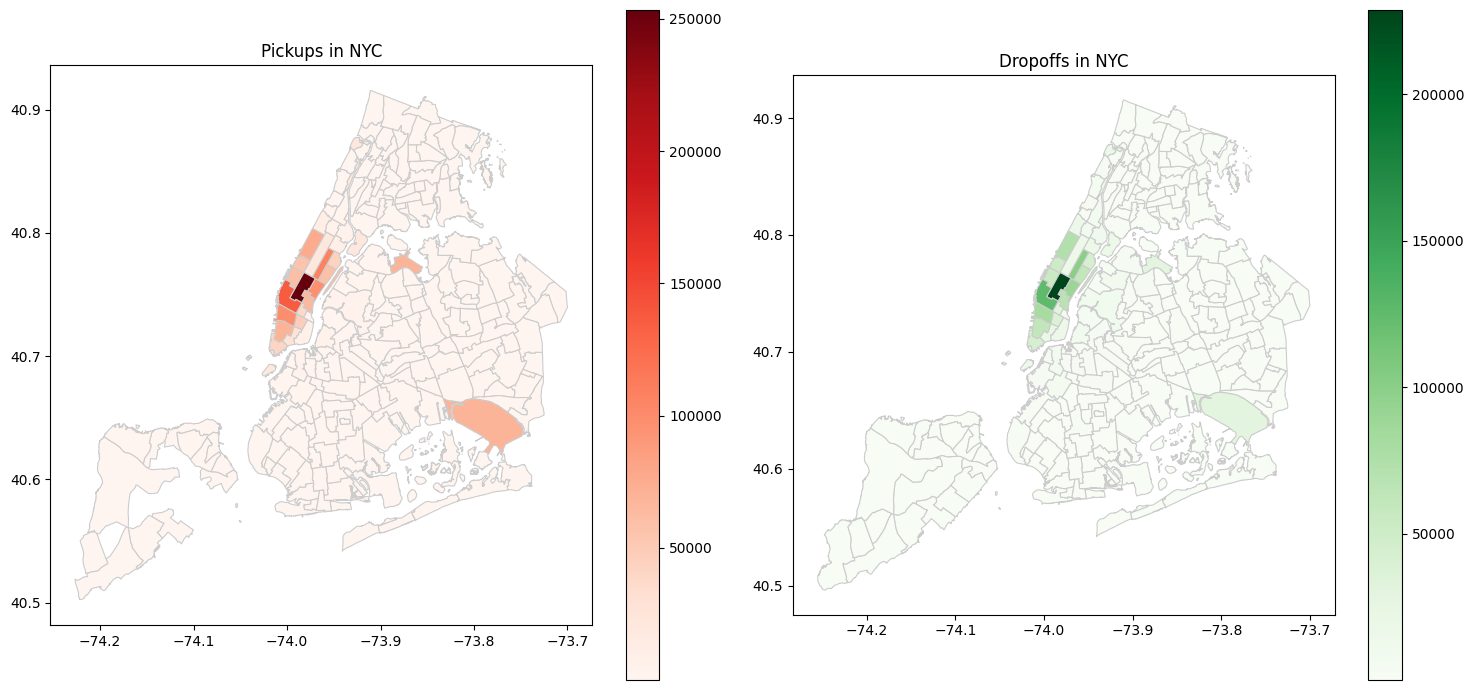

In [ ]:
pickups_counts = pickup_neighborhoods.groupby('ntaname').size().reset_index(name='pickup_count')
dropoffs_counts = dropoff_neighborhoods.groupby('ntaname').size().reset_index(name='dropoff_count')

# Merge counts with neighborhood geometries
nyc_neighborhoods = nyc_neighborhoods.merge(pickups_counts, on='ntaname', how='left')
nyc_neighborhoods = nyc_neighborhoods.merge(dropoffs_counts, on='ntaname', how='left')

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot pickups
nyc_neighborhoods.plot(column='pickup_count', cmap='Reds', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
ax[0].set_title('Pickups in NYC')

# Plot dropoffs
nyc_neighborhoods.plot(column='dropoff_count', cmap='Greens', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True)
ax[1].set_title('Dropoffs in NYC')

plt.tight_layout()
plt.show()

The maps show that the distribution of both pickup and dropoff locations in NYC is quite similar, with high traffic concentrated in the same neighborhoods. This indicates that these areas are central to the city's transportation network, suggesting they are both major sources and destinations for trips. The consistent shading in these neighborhoods reflects high activity levels in both pickup and dropoff scenarios, which could be due to their roles as key commercial hubs, transportation centers, or densely populated areas. Overall, the similarity in distribution demonstrates the significance of these locations in the city's transportation dynamics.

3. Which neighbourhood(s) is/are the quietest at night, between midnight
and 5AM? [2 marks]


In [ ]:
# Parse datetime to filter trips between midnight and 5 AM
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Filter for trips starting between midnight and 5 AM and ending before 5 AM
nighttime_trips = df[
    (df['pickup_datetime'].dt.hour >= 0) & (df['pickup_datetime'].dt.hour < 5) &
    (df['dropoff_datetime'].dt.hour < 5)
]

# Convert to a GeoDataFrame
gdf_nighttime_pickup = gpd.GeoDataFrame(nighttime_trips, geometry='geometry', crs="EPSG:4326")

# Spatial join to get neighborhoods using 'predicate' instead of 'op'
gdf_nighttime_pickup = gpd.sjoin(gdf_nighttime_pickup, nyc_neighborhoods, predicate='intersects')

# Count trips per neighborhood
quiet_neighborhoods = gdf_nighttime_pickup['ntaname'].value_counts().reset_index()
quiet_neighborhoods.columns = ['neighborhood', 'trip_count']

# Find the minimum trip count
min_trip_count = quiet_neighborhoods['trip_count'].min()
print(f"The minimum number of trips in quiet neighborhoods is: {min_trip_count}")

# Get the neighborhoods with the minimum trip count
quiet_neighborhoods_sorted = quiet_neighborhoods[quiet_neighborhoods['trip_count'] == min_trip_count]



# Sort neighborhoods by trip count (ascending) and get the top 3 quiet neighborhoods
top_3_quiet_neighborhoods = quiet_neighborhoods.sort_values(by='trip_count').head(3)

# Display the top 3 quiet neighborhoods
print("\nTop 3 quiet neighborhoods with the fewest trips:")
print(top_3_quiet_neighborhoods)
# Display the most likely quiet neighborhood (with minimum trip count)
print("\nThe most quietest neighborhood:")
print(quiet_neighborhoods_sorted)


The minimum number of trips in quiet neighborhoods is: 1

Top 3 quiet neighborhoods with the fewest trips:
                                   neighborhood  trip_count
191                       Oakwood-Oakwood Beach           1
186  Annadale-Huguenot-Prince's Bay-Eltingville           2
187           Old Town-Dongan Hills-South Beach           2

The most quietest neighborhood:
              neighborhood  trip_count
191  Oakwood-Oakwood Beach           1


4. Which neighbourhood(s) is/are the busiest at night, between midnight
and 5AM? [2 marks]


In [ ]:
busiest_neighborhoods = gdf_nighttime_pickup['ntaname'].value_counts().reset_index()
busiest_neighborhoods.columns = ['neighborhood', 'trip_count']

# Find the maximum trip count
max_trip_count = busiest_neighborhoods['trip_count'].max()
print("The maximum number of trips in busy neighborhoods is ",max_trip_count)
# Filter neighborhoods that have the maximum trip count
busiest_neighborhoods_filtered = busiest_neighborhoods[busiest_neighborhoods['trip_count'] == max_trip_count]
# Sort neighborhoods by trip count (ascending) and get the last 3 busiest neighborhoods
top_3_busy_neighborhoods = busiest_neighborhoods.sort_values(by='trip_count').tail(3)
# Display the busiest neighborhoods

# Display the top 3  neighborhoods
print("\nTop 3 busiest neighborhoods with the more trips:")
print(top_3_busy_neighborhoods)
print("Busiest neighborhoods between midnight and 5 AM:")
print(busiest_neighborhoods_filtered)

The maximum number of trips in busy neighborhoods is  14507

Top 3 busiest neighborhoods with the more trips:
                                 neighborhood  trip_count
2                                West Village        8727
1  Hudson Yards-Chelsea-Flatiron-Union Square       11141
0                       Midtown-Midtown South       14507
Busiest neighborhoods between midnight and 5 AM:
            neighborhood  trip_count
0  Midtown-Midtown South       14507
